In [22]:
#import lib
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#libraries for RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# libraries for RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

#libraries for Elastic Net
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet

# libraries to plot Venn diagram
from matplotlib_venn import venn3

# lib for model experiment
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# libraries for descriptive stats
from scipy.stats import mannwhitneyu


In [23]:
#import dataset
github_raw_url = 'https://raw.githubusercontent.com/mohandaz/HIA-303-Project/main/wdbc.data'

# Fetch data from the URL
response = requests.get(github_raw_url)

if response.status_code == 200:
    # Load breast cancer data from CSV file using Pandas
    bca = pd.read_csv(StringIO(response.text), header=None)
else:
    print(f"Failed to fetch data. Status Code: {response.status_code}")

In [24]:
#prepare dataframe

# Rename columns
column_names = [
    'ID', 'Diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
    'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

bca.columns = column_names
bca.head(20)

# Move the 'Diagnosis' column to the last
diagnosis_column = bca.pop('Diagnosis')
bca['Diagnosis'] = diagnosis_column

# Add a new column 'unique ID' with unique values
bca.insert(0, 'PID', range(1, len(bca) + 1))

# Remove the 'Patient ID' column
bca.drop('ID', axis=1, inplace=True)
bca.head(20)

,PID,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,M
1,2,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,M
2,3,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,M
3,4,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,M
4,5,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,M
5,6,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,M
6,7,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,M
7,8,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,M
8,9,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,M
9,10,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,M


In [39]:
# Data Preprocessing
# Check for duplicate rows
duplicate_rows = bca[bca.duplicated()]
print(duplicate_rows)

# OUTLIERS
# Selecting all continuous variables for outlier detection
continuous_columns = bca.columns[1:31]

# Create individual horizontal box plots for each continuous variable
plt.figure(figsize=(15, 20))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=bca[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}', fontsize=10)
    plt.ylabel(column, fontsize=11)

# Adjust layout to prevent overlapping
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the horizontal and vertical spacing
plt.show()

outlier_threshold = 1.5
# Calculate the percentage of outliers for each column
outliers_percentage = ((bca[continuous_columns] < bca[continuous_columns].quantile(0.25) - outlier_threshold * (bca[continuous_columns].quantile(0.75) - bca[continuous_columns].quantile(0.25))) |
                       (bca[continuous_columns] > bca[continuous_columns].quantile(0.75) + outlier_threshold * (bca[continuous_columns].quantile(0.75) - bca[continuous_columns].quantile(0.25)))).mean() * 100

print(f'percentage of outlying values \n{outliers_percentage}')

# Calculate statistics for each continuous variable
statistics = []

for column in continuous_columns:
    q1 = bca[column].quantile(0.25)
    q3 = bca[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    min_value = bca[column].min()
    max_value = bca[column].max()

    statistics.append({
        'Variable': column,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Minimum Value': min_value,
        'Maximum Value': max_value
    })

# Create a DataFrame from the list of dictionaries
statistics_df = pd.DataFrame(statistics)


# OUTLIERS CORRECTION
# Create a copy of the original DataFrame
bca_capped = bca.copy()
start_column = 1
end_column = 31

# Iterate over each variable in columns start_column to end_column
for column in bca_capped.columns[start_column:end_column + 1]:
    # Check if the column contains numeric data
    if pd.api.types.is_numeric_dtype(bca_capped[column]):
        q1 = bca[column].quantile(0.25)
        q3 = bca[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Cap values above the upper bound to the upper bound value
        bca_capped[column] = np.clip(bca_capped[column], lower_bound, upper_bound)

# Check normality using Kolmogorov–Smirnov test and QQ plot
for column in continuous_columns:
    # Kolmogorov–Smirnov test
    kstest_result = kstest(bca[column], 'norm')
    p_value_formatted = "{:.3f}".format(kstest_result.pvalue)
    print(f'Kolmogorov–Smirnov test for {column}: p-value = {kstest_result.pvalue}')

# Combine QQ plots into subplots
num_plots = len(continuous_columns)
num_cols = 6
num_rows = 5

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

for i, column in enumerate(continuous_columns):
    row = i // num_cols
    col = i % num_cols

    # QQ plot
    sm.qqplot(bca[column], line='s', ax=axes[row, col])
    axes[row, col].set_title(f'QQ Plot for {column}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Calculate the Spearman correlation matrix
correlation_matrix = bca[continuous_columns].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(30, 35))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 15})  # Increase annotation size
plt.title('Spearman Correlation Heatmap for Continuous Variables', fontsize=40)  # Increase title font size
plt.xticks(fontsize=25)  # Increase x-axis tick font size
plt.yticks(fontsize=25)  # Increase y-axis tick font size
plt.show()

# Create individual box plots for each continuous variable in the corrected DataFrame

plt.figure(figsize=(15, 20))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=bca_capped[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

# Missing values
# Check for missing values
missing_values = bca.isnull().sum()
print(missing_values)

percentage of outlying values 
radius_mean                 2.460457
texture_mean                1.230228
perimeter_mean              2.284710
area_mean                   4.393673
smoothness_mean             1.054482
compactness_mean            2.811951
concavity_mean              3.163445
concave_points_mean         1.757469
symmetry_mean               2.636204
fractal_dimension_mean      2.636204
radius_se                   6.678383
texture_se                  3.514938
perimeter_se                6.678383
area_se                    11.423550
smoothness_se               5.272408
compactness_se              4.920914
concavity_se                3.866432
concave_points_se           3.339192
symmetry_se                 4.745167
fractal_dimension_se        4.920914
radius_worst                2.987698
texture_worst               0.878735
perimeter_worst             2.636204
area_worst                  6.151142
smoothness_worst            1.230228
compactness_worst           2.811951
concavi

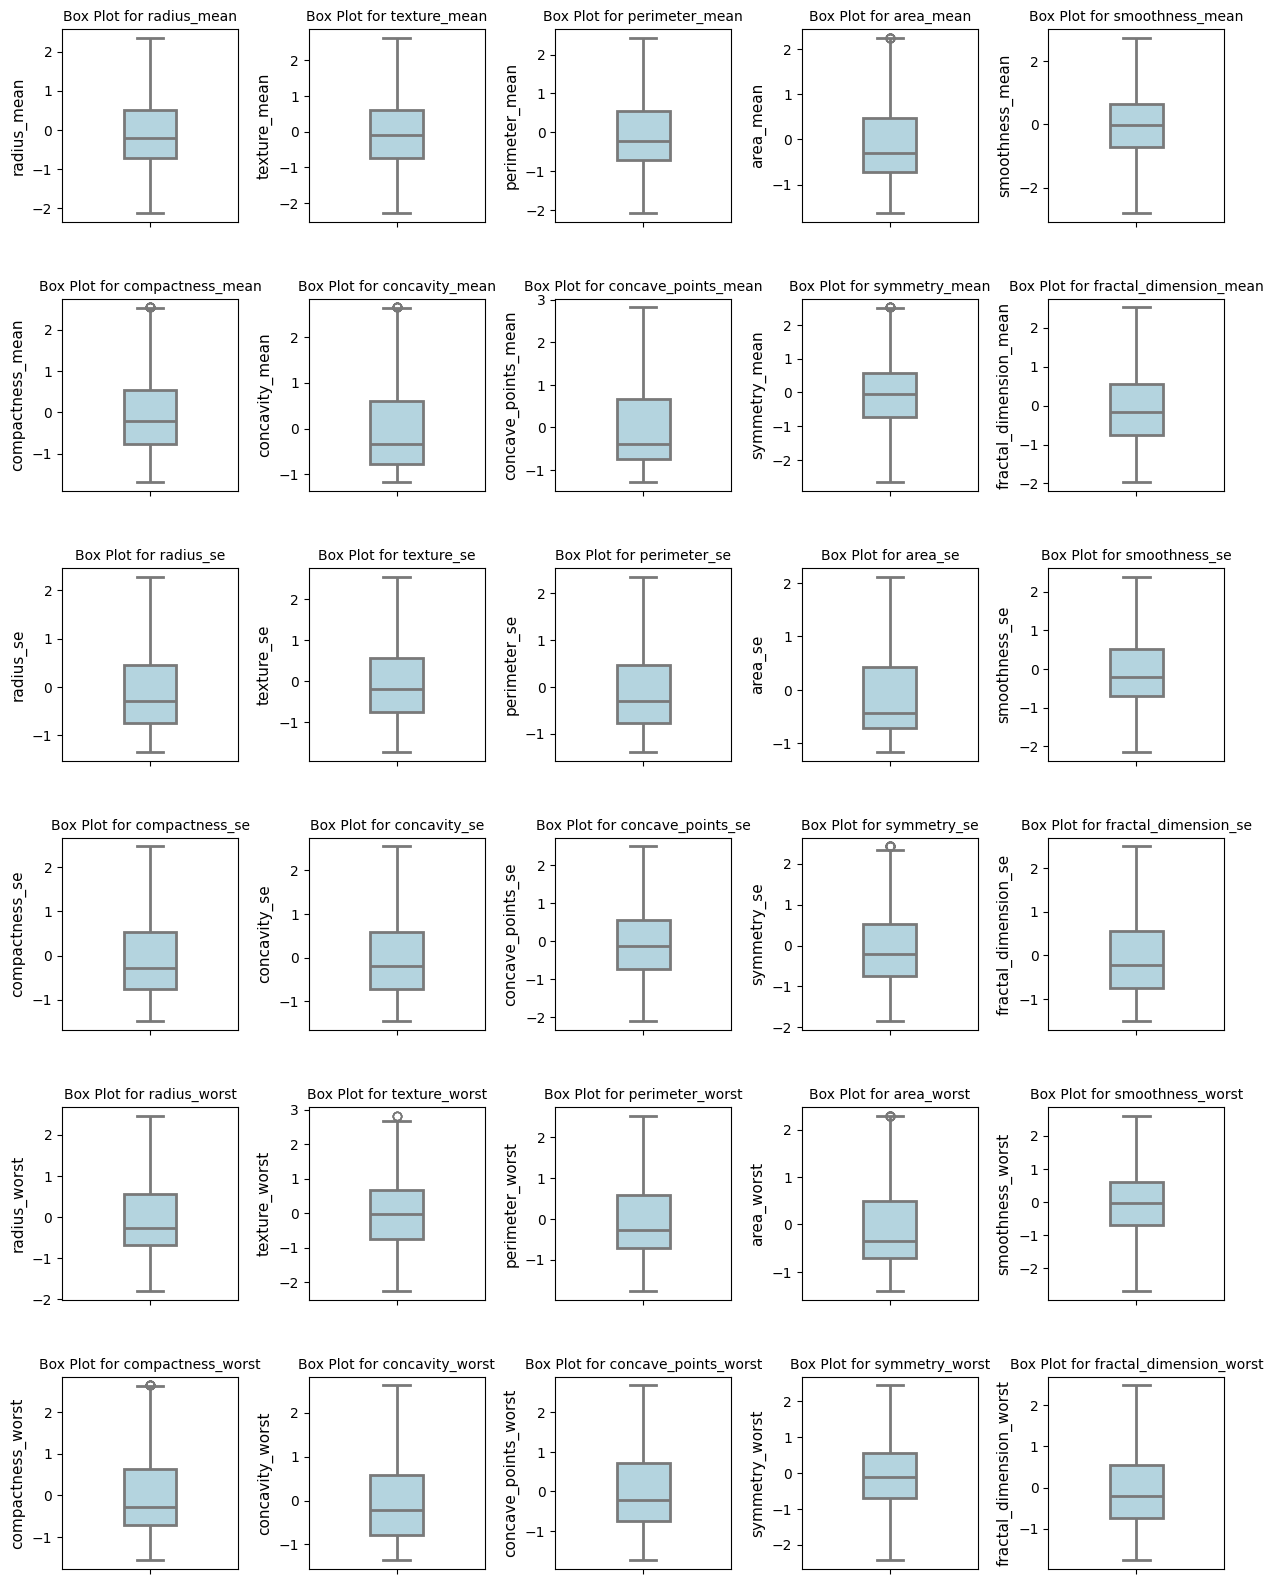

In [26]:
# Data Scaling
# Create a copy of the DataFrame for feature scaling
bca_capped_scaled = bca_capped.copy()

# Select only the numeric columns for feature scaling
numeric_columns = bca_capped_scaled.select_dtypes(include='number').columns

# Instantiate StandardScaler
scaler = StandardScaler()

# Perform feature scaling on selected columns
bca_capped_scaled[continuous_columns] = scaler.fit_transform(bca_capped_scaled[continuous_columns])


# Create individual box plots for each continuous variable in the scaled DataFrame

plt.figure(figsize=(15, 20))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=bca_capped_scaled[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}', fontsize=10)
    plt.ylabel(column, fontsize=11)

# Adjust layout to prevent overlapping
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the horizontal and vertical spacing
plt.show()

Class distribution before oversampling:
B    357
M    212
Name: Diagnosis, dtype: int64
Class distribution after oversampling:
M    357
B    357
Name: Diagnosis, dtype: int64


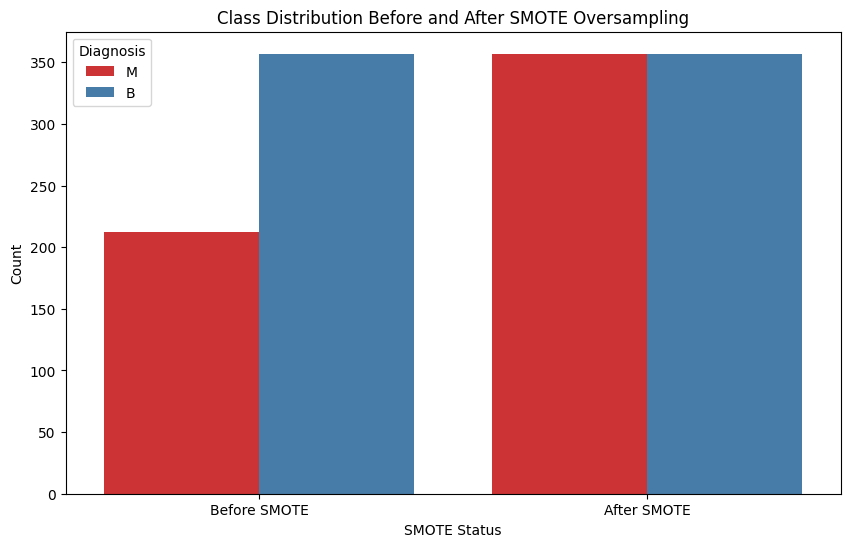

In [27]:
# oversampling
#SMOTE
# Separate features and target variable
X = bca_capped_scaled.drop('Diagnosis', axis=1)
y = bca_capped_scaled['Diagnosis']

# SMOTE
smote = SMOTE(random_state=43)

# Fit and apply SMOTE on the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled data into a new DataFrame
bca_capped_scaled_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Diagnosis')], axis=1)

# Display the class distribution after oversampling
print("Class distribution before oversampling:")
print(bca_capped_scaled['Diagnosis'].value_counts())

print("Class distribution after oversampling:")
print(bca_capped_scaled_balanced['Diagnosis'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='Source', data=pd.concat([bca_capped_scaled.assign(Source='Before SMOTE'), bca_capped_scaled_balanced.assign(Source='After SMOTE')]),
              hue='Diagnosis', palette='Set1')
plt.title('Class Distribution Before and After SMOTE Oversampling')
plt.xlabel('SMOTE Status')
plt.ylabel('Count')
plt.legend(title='Diagnosis')
plt.show()

In [28]:
#prepare % partition training % testing data
# Create a copy of the DataFrame for mapping and modification
bca_processed = bca_capped_scaled_balanced.copy()

# Map 'M' to 1 and 'B' to 0 in the 'Diagnosis' column
bca_processed['Diagnosis'] = bca_processed['Diagnosis'].map({'M': 1, 'B': 0})

# Create a new column 'dx' with 1 for 'M' and 0 for 'B'
bca_processed['Malignant'] = (bca_processed['Diagnosis'] == 1).astype(int)

# Drop the original 'Diagnosis' column
bca_processed = bca_processed.drop('Diagnosis', axis=1)


"""SPLITTING DATA"""
# Perform train-test split (80:20) using bca_balanced_2
X_train, X_test, y_train, y_test = train_test_split(bca_processed.drop('Malignant', axis=1),
                                                    bca_processed['Malignant'],
                                                    test_size=0.2,
                                                    random_state=43)

# Create DataFrames for training and testing sets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.head(20)



,PID,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Malignant
63,64,-1.465324,-1.289426,-1.404605,-1.241875,-1.393731,-0.318423,-0.366447,-0.711503,2.049044,...,-1.061062,-1.287685,-1.135894,-1.517887,-0.575110,-0.654138,-0.970486,0.754055,0.097479,0
511,512,0.223873,-1.088653,0.135329,0.134179,-0.844458,-1.075383,-0.714789,-0.615491,-0.569580,...,-1.333831,-0.156762,-0.188768,-0.821037,-1.042440,-0.804173,-0.533787,-1.007342,-1.371933,0
502,503,-0.456361,-0.701447,-0.447032,-0.535820,1.428700,0.106974,-0.374573,-0.419213,0.520873,...,-0.702330,-0.627484,-0.626875,1.156510,-0.523962,-0.404756,-0.464354,0.518087,-0.498297,0
661,214,0.742307,0.699741,0.780662,0.619698,0.316628,0.684593,1.038226,1.156245,0.955052,...,0.695777,0.950301,0.640806,0.492375,0.550041,0.451601,0.870942,1.003445,0.301957,1
542,543,0.202897,1.473594,0.137066,0.094517,-0.988541,-0.629922,-0.621474,-0.486235,0.125392,...,1.097943,0.021755,-0.049466,-1.175292,-0.786705,-0.545667,-0.077750,-0.286433,-0.862520,0
409,410,-0.537269,-0.319023,-0.570366,-0.569254,-0.688672,-0.769356,-0.742554,-0.585704,0.609185,...,0.534221,-0.554511,-0.504407,-0.368130,-0.493134,-0.664276,-0.293664,1.075491,-0.900069,0
220,221,-0.123735,-1.456736,-0.159109,-0.232288,0.014193,-0.326530,-0.650863,-0.609640,-1.717628,...,-1.537167,-0.219087,-0.302398,-0.049749,-0.017396,-0.470650,-0.518408,-0.921874,0.240164,0
601,93,1.751053,1.008693,1.645462,1.870406,-0.411457,0.507204,0.807863,0.986781,0.948989,...,0.926586,1.518397,1.817804,-0.516882,0.662247,0.954476,0.816412,1.651759,0.185341,1
12,13,1.530401,1.325404,1.774278,1.583986,0.082944,2.541404,1.619323,1.682135,2.264063,...,0.709454,1.409179,1.014446,-1.278429,0.983827,0.482272,0.945477,0.557105,1.186395,1
276,277,-0.818952,-1.217721,-0.857855,-0.797067,-0.181088,-1.307234,-1.157301,-1.202651,0.563109,...,-1.100738,-0.918749,-0.824675,-0.282929,-1.235959,-1.337125,-1.575895,-0.219544,-1.219234,0


Cross-Validation AUC Scores: [0.99137409 0.99522783 0.99784483 0.99553571 1.        ]
Average AUC Score: 0.9959964932787845

Feature Importances:
                     Feature  Importance
22          perimeter_worst    0.201763
20             radius_worst    0.106378
7       concave_points_mean    0.098456
27     concave_points_worst    0.088601
23               area_worst    0.086836
6            concavity_mean    0.076977
2            perimeter_mean    0.053214
3                 area_mean    0.039818
26          concavity_worst    0.036221
13                  area_se    0.028930
0               radius_mean    0.025116
10                radius_se    0.021220
1              texture_mean    0.020650
21            texture_worst    0.018812
24         smoothness_worst    0.016055
5          compactness_mean    0.009664
12             perimeter_se    0.009526
28           symmetry_worst    0.008941
25        compactness_worst    0.008755
29  fractal_dimension_worst    0.008040
11           

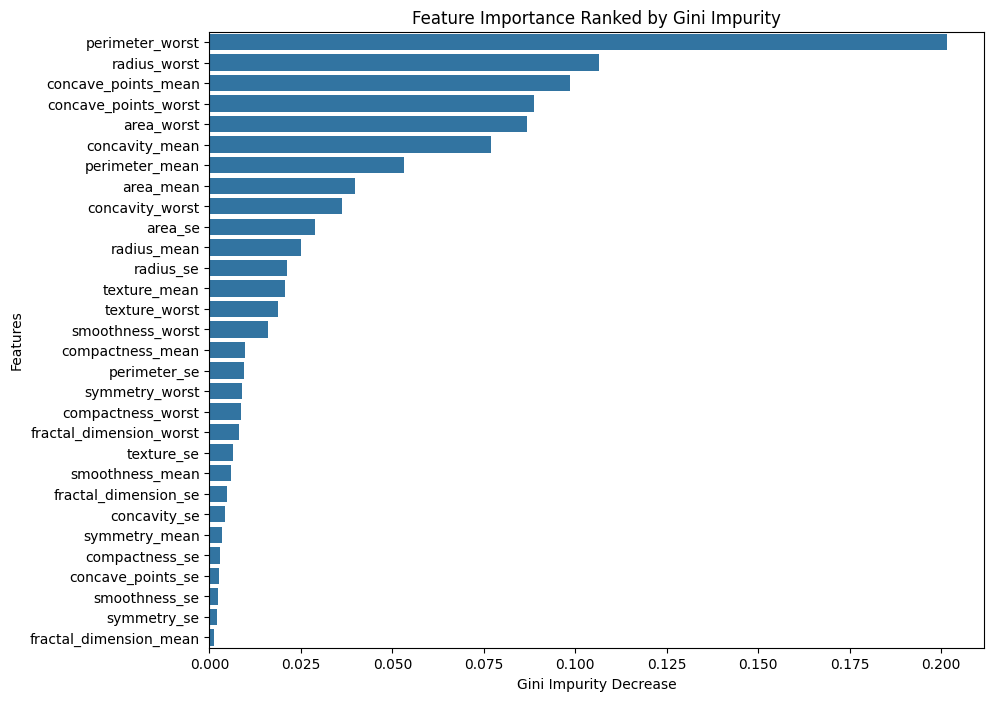

In [29]:
#feature selection using Random forest
train_data = train_data.drop('PID', axis=1)
columns_to_check_cont = train_data.columns[0:30]

# RF feature importance
# Extract features and target variable
columns_to_check_cont = train_data.columns[0:30]
X = train_data[columns_to_check_cont]
y = train_data['Malignant']

# Initialize RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# 5-Fold Cross-Validation using AUC as the scoring metric
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')

# Fit the Random Forest model to get feature importances
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': columns_to_check_cont, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Cross-Validation AUC Scores:", cross_val_scores)
print("Average AUC Score:", np.mean(cross_val_scores))
print("\nFeature Importances:\n", feature_importance_df)

# Sort the DataFrame by importance in ascending order for the plot
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

plt.title('Feature Importance Ranked by Gini Impurity')
plt.xlabel('Gini Impurity Decrease')
plt.ylabel('Features')

plt.show()

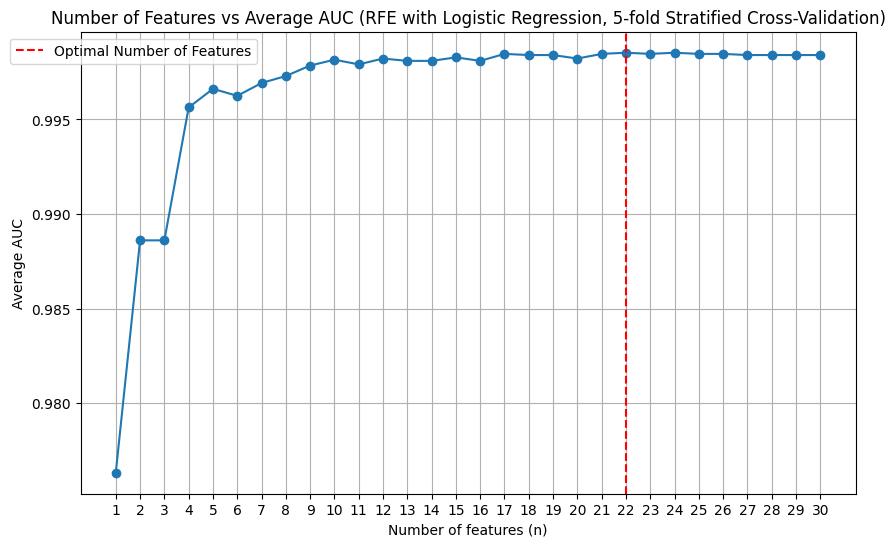

Index(['area_mean', 'concavity_mean', 'concave_points_mean', 'area_se',
       'compactness_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'concave_points_worst',
       'symmetry_worst'],
      dtype='object')


In [30]:
#feature selection using RFE
# RFE feature selection
X = train_data[columns_to_check_cont]
y = train_data['Malignant']

# Initialize Logistic Regression
logistic_model = LogisticRegression()

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5)

# Initialize RFE with Logistic Regression
rfe = RFE(estimator=logistic_model)

# Lists to store results
num_features_list = []
auc_list = []

# Iterate over different numbers of features
for num_features in range(1, len(X.columns) + 1):
    rfe.n_features_to_select = num_features

    # Initialize list for cross-validation results
    cv_auc_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rfe.fit(X_train, y_train)
        RFE_selected_features = X_train.columns[rfe.support_]

        # Train and evaluate the model on the test set
        logistic_model.fit(X_train[RFE_selected_features], y_train)
        y_pred = logistic_model.predict_proba(X_test[RFE_selected_features])[:, 1]

        # Calculate AUC
        auc_score = roc_auc_score(y_test, y_pred)
        cv_auc_list.append(auc_score)

    # Calculate average AUC across folds
    avg_auc = np.mean(cv_auc_list)

    # Append results to lists
    num_features_list.append(num_features)
    auc_list.append(avg_auc)

# Find the index corresponding to the maximum AUC
optimal_num_features_index = np.argmax(auc_list)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, auc_list, marker='o')
plt.title('Number of Features vs Average AUC (RFE with Logistic Regression, 5-fold Stratified Cross-Validation)')
plt.xlabel('Number of features (n)')
plt.ylabel('Average AUC')

# Set x-axis ticks at the interval of 1 integer
plt.xticks(range(min(num_features_list), max(num_features_list) + 1, 1))

plt.axvline(num_features_list[optimal_num_features_index], linestyle='--', color='red', label='Optimal Number of Features')
plt.legend(loc='upper left', bbox_to_anchor=(-0.1, 1))  # Move legend slightly to the right and up
plt.grid(True)
plt.show()

# # Set the optimal number of features (automated)
# optimal_num_features = num_features_list[optimal_num_features_index]

# Set the optimal number of features (to manual set features)
optimal_num_features = 12

# Initialize RFE with the optimal number of features
rfe.n_features_to_select = optimal_num_features
rfe.fit(X, y)

# Get the selected features
RFE_selected_features_withHighAUC = X.columns[rfe.support_]
print(RFE_selected_features_withHighAUC)


Best Alpha: 0.0016297508346206436
Best Rho (l1_ratio): 1.0
Selected Features: Index(['radius_mean', 'concavity_mean', 'fractal_dimension_mean', 'radius_se',
       'texture_se', 'area_se', 'texture_worst', 'smoothness_worst',
       'concave_points_worst', 'fractal_dimension_worst'],
      dtype='object')


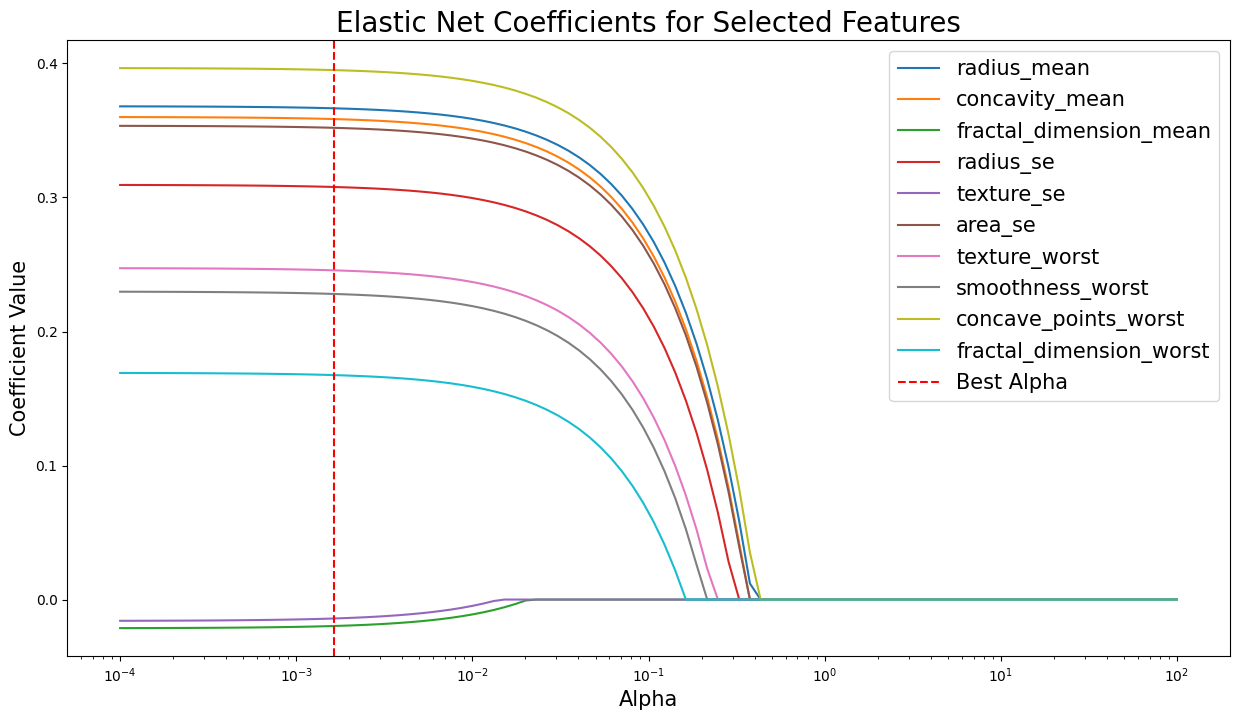

In [31]:
# feature selection (Elastic Net)
# Elastic Net feature selection
target_variable = 'Malignant'
X_train = train_data.drop(['Malignant'], axis=1)
y_train = train_data[target_variable]

# Split the training data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

# Create Elastic Net model with cross-validation
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 1.0, 100),
    alphas=np.logspace(-4, 2, 100),
    cv=5,
    random_state=42,
    max_iter=10000  # Increase max_iter if needed
)

# Fit the Elastic Net model to the training data
elastic_net.fit(X_train_split, y_train_split)

# Get the best alpha and rho
best_alpha = elastic_net.alpha_
best_rho = elastic_net.l1_ratio_

# Print the best alpha and rho
print(f'Best Alpha: {best_alpha}')
print(f'Best Rho (l1_ratio): {best_rho}')

# Predict the probability of positive class for validation set
y_val_pred_proba = elastic_net.predict(X_val_split)

# Train Elastic Net model with best parameters
final_elastic_net = ElasticNetCV(
    l1_ratio=best_rho,
    alphas=[best_alpha],
    cv=5,
    random_state=42,
    max_iter=10000
)

final_elastic_net.fit(X_train, y_train)

# Select features based on the best Elastic Net model
feature_selector = SelectFromModel(final_elastic_net, threshold='mean')
X_train_selected = feature_selector.fit_transform(X_train, y_train)

# Get the selected feature names
EN_selected_feature = X_train.columns[feature_selector.get_support()]

# Print the selected feature names
print(f'Selected Features: {EN_selected_feature}')

# Store coefficients in a DataFrame
EN_selected_feature_coef = pd.DataFrame(index=elastic_net.alphas_)

# Plot the coefficients of the selected features with respect to alpha values
plt.figure(figsize=(15, 8))

# Iterate over the selected features
for feature in EN_selected_feature:
    # Extract the coefficients using a single feature at a time
    coef_values = []
    for alpha in elastic_net.alphas_:
        elastic_net_per_alpha = ElasticNet(alpha=alpha, l1_ratio=best_rho, max_iter=10000)
        elastic_net_per_alpha.fit(X_train[[feature]], y_train)
        coef_values.append(elastic_net_per_alpha.coef_[0])

    # Plot the coefficients against the alpha values
    plt.plot(elastic_net.alphas_, coef_values, label=feature)

    # Store coefficients in the DataFrame
    EN_selected_feature_coef[feature] = coef_values

# Plot a vertical line at the position of the best alpha
plt.axvline(x=best_alpha, color='r', linestyle='--', label='Best Alpha')

# Customize the plot
plt.xscale('log')  # Use log scale for better visualization
plt.xlabel('Alpha', fontsize = 15)
plt.ylabel('Coefficient Value', fontsize = 15)
plt.title('Elastic Net Coefficients for Selected Features', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

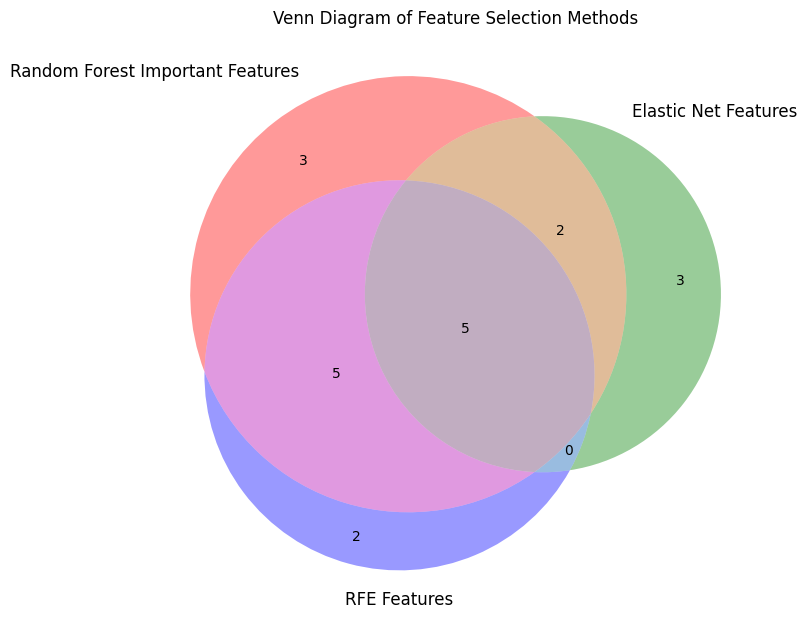

Common features across all three methods: {'smoothness_worst', 'area_se', 'texture_worst', 'concavity_mean', 'concave_points_worst'}
Shared between Random Forest and Elastic Net: {'radius_mean', 'radius_se'}
Shared between Random Forest and RFE: {'radius_worst', 'area_worst', 'concave_points_mean', 'perimeter_worst', 'area_mean'}
Shared between Elastic Net and RFE: set()


In [32]:
# venn diagram for features
# Venn diagram for feature selection
# Sample lists of features.
RF_selected_features = [
    "perimeter_worst",
    "radius_worst",
    "concave_points_mean",
    "concave_points_worst",
    "area_worst",
    "concavity_mean",
    "perimeter_mean",
    "area_mean",
    "concavity_worst",
    "area_se",
    "radius_mean",
    "radius_se",
    "texture_mean",
    "texture_worst",
    "smoothness_worst"
]

EN_selected_features = ['radius_mean', 'concavity_mean', 'fractal-dimension_mean', 'radius_se', 'texture_se', 'area_se', 'texture_worst', 'smoothness_worst', 'concave_points_worst', 'fractal_dimension_worst']
RFE_selected_features_withHighAUC = ['area_mean', 'concavity_mean', 'concave_points_mean', 'area_se',
       'compactness_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'concave_points_worst',
       'symmetry_worst']

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venn3([set(RF_selected_features), set(EN_selected_features), set(RFE_selected_features_withHighAUC)],
      set_labels=('Random Forest Important Features', 'Elastic Net Features', 'RFE Features'))
plt.title("Venn Diagram of Feature Selection Methods")
plt.show()

# Convert lists to sets
RF_set = set(RF_selected_features)
EN_set = set(EN_selected_features)
RFE_set = set(RFE_selected_features_withHighAUC)

# Find
common_features = RF_set.intersection(EN_set, RFE_set)
print("Common features across all three methods:", common_features)


# Find unique and shared features
shared_RF_EN = RF_set.intersection(EN_set) - RFE_set
shared_RF_RFE = RF_set.intersection(RFE_set) - EN_set
shared_EN_RFE = EN_set.intersection(RFE_set) - RF_set

# Print results
print("Shared between Random Forest and Elastic Net:", shared_RF_EN)
print("Shared between Random Forest and RFE:", shared_RF_RFE)
print("Shared between Elastic Net and RFE:", shared_EN_RFE)

In [33]:
### model experiment ##
X = train_data.drop('Malignant', axis=1)
y = train_data['Malignant']

# Define the feature sets
RF_selected_features = [ "perimeter_worst",
 "radius_worst",
 "concave_points_mean",
 "concave_points_worst",
 "area_worst",
 "concavity_mean",
 "perimeter_mean",
 "area_mean",
 "concavity_worst",
 "area_se",
 "radius_mean",
 "radius_se",
 "texture_mean",
 "texture_worst",
 "smoothness_worst"]
EN_selected_features = ['radius_mean', 'concavity_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'area_se', 'texture_worst', 'smoothness_worst', 'concave_points_worst', 'fractal_dimension_worst']
RFE_selected_features_withHighAUC = ['area_mean', 'concavity_mean', 'concave_points_mean', 'area_se',
       'compactness_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'concave_points_worst',
       'symmetry_worst']
# shared_features = ['texture_worst', 'area_se', 'concave_points_worst', 'concavity_mean', 'smoothness_worst', 'radius_mean', 'radius_se', 'area_mean', 'radius_worst', 'perimeter_worst', 'concave_points_mean', 'area_worst']
shared_all_features= ['texture_worst', 'smoothness_worst', 'area_se', 'concavity_mean', 'concave_points_worst']
# List of feature sets
feature_sets = [RF_selected_features, EN_selected_features, RFE_selected_features_withHighAUC, shared_all_features]

# Function to calculate specificity and NPV
def specificity_npv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    npv = tn / (tn+fn)
    return specificity, npv

# Model Definitions
models = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10, 100, 150, 200], 'solver': ['liblinear', 'lbfgs']}),
    'SVM': (SVC(probability=True), {'C': [0.01, 0.05, 0.1, 1, 10, 15, 20], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9, 12, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}),
    'Decision Tree': (DecisionTreeClassifier(), {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 20, 30], 'min_samples_split': [2, 5, 10, 15, 20]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [5, 10, 20, 50, 100, 200, 300], 'max_depth': [None, 10, 20, 30, 40], 'min_samples_split': [1, 2, 5, 10]}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [10, 20, 50, 100, 200, 250, 300], 'max_depth': [2, 3, 6, 9], 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5]})
}

# Loop through each model and feature set
for model_name, (model, param_grid) in models.items():
    print(f"\n--- Evaluating {model_name} ---")
    for i, features in enumerate(feature_sets, start=1):
        X_selected = X[features]
        X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

        # Grid Search for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
        grid_search.fit(X_train, y_train)

        # Best hyperparameters
        best_params = grid_search.best_params_
        print(f"\nBest parameters for {model_name} with feature set {i}: {best_params}")

        # Retrain with best parameters and evaluate
        best_model = model.set_params(**best_params)
        best_model.fit(X_train, y_train)
        y_val_pred = best_model.predict(X_val)
        y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

        # Calculate metrics
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)
        val_sensitivity = recall_score(y_val, y_val_pred)
        val_specificity, val_npv = specificity_npv(y_val, y_val_pred)
        val_ppv = precision_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)

        # Report metrics
        print(f"  AUC: {val_auc}")
        print(f"  Accuracy: {val_accuracy}")
        print(f"  Sensitivity (Recall): {val_sensitivity}")
        print(f"  Specificity: {val_specificity}")
        print(f"  PPV (Precision): {val_ppv}")
        print(f"  NPV: {val_npv}")
        print(f"  F1 Score: {val_f1}")





--- Evaluating Logistic Regression ---


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Best parameters for Logistic Regression with feature set 1: {'C': 10, 'solver': 'liblinear'}
  AUC: 0.9972611077297626
  Accuracy: 0.9565217391304348
  Sensitivity (Recall): 0.9354838709677419
  Specificity: 0.9811320754716981
  PPV (Precision): 0.9830508474576272
  NPV: 0.9285714285714286
  F1 Score: 0.9586776859504132

Best parameters for Logistic Regression with feature set 2: {'C': 1, 'solver': 'liblinear'}
  AUC: 0.9966524650030433
  Accuracy: 0.9652173913043478
  Sensitivity (Recall): 0.9516129032258065
  Specificity: 0.9811320754716981
  PPV (Precision): 0.9833333333333333
  NPV: 0.9454545454545454
  F1 Score: 0.9672131147540983

Best parameters for Logistic Regression with feature set 3: {'C': 10, 'solver': 'liblinear'}
  AUC: 0.9975654290931224
  Accuracy: 0.9739130434782609
  Sensitivity (Recall): 0.967741935483871
  Specificity: 0.9811320754716981
  PPV (Precision): 0.9836065573770492
  NPV: 0.9629629629629629
  F1 Score: 0.975609756097561

Best parameters for Logistic Regr

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
175 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut


Best parameters for Random Forest with feature set 1: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 20}
  AUC: 0.9942178940961657
  Accuracy: 0.9565217391304348
  Sensitivity (Recall): 0.9516129032258065
  Specificity: 0.9622641509433962
  PPV (Precision): 0.9672131147540983
  NPV: 0.9444444444444444
  F1 Score: 0.959349593495935


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
175 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut


Best parameters for Random Forest with feature set 2: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 20}
  AUC: 0.9919354838709677
  Accuracy: 0.9565217391304348
  Sensitivity (Recall): 0.9516129032258065
  Specificity: 0.9622641509433962
  PPV (Precision): 0.9672131147540983
  NPV: 0.9444444444444444
  F1 Score: 0.959349593495935


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
175 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut


Best parameters for Random Forest with feature set 3: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
  AUC: 0.9928484479610469
  Accuracy: 0.9739130434782609
  Sensitivity (Recall): 0.967741935483871
  Specificity: 0.9811320754716981
  PPV (Precision): 0.9836065573770492
  NPV: 0.9629629629629629
  F1 Score: 0.975609756097561


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
175 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut


Best parameters for Random Forest with feature set 4: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 20}
  AUC: 0.9948265368228849
  Accuracy: 0.9565217391304348
  Sensitivity (Recall): 0.9516129032258065
  Specificity: 0.9622641509433962
  PPV (Precision): 0.9672131147540983
  NPV: 0.9444444444444444
  F1 Score: 0.959349593495935

--- Evaluating XGBoost ---

Best parameters for XGBoost with feature set 1: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 100}
  AUC: 0.9945222154595252
  Accuracy: 0.9565217391304348
  Sensitivity (Recall): 0.9516129032258065
  Specificity: 0.9622641509433962
  PPV (Precision): 0.9672131147540983
  NPV: 0.9444444444444444
  F1 Score: 0.959349593495935

Best parameters for XGBoost with feature set 2: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 250}
  AUC: 0.9920876445526476
  Accuracy: 0.9565217391304348
  Sensitivity (Recall): 0.9516129032258065
  Specificity: 0.9622641509433962
  PPV (Precision): 0.9672131147540983
  NPV: 0.

Logistic Regression Performance:
  Accuracy: 0.972027972027972
  AUC: 0.98642266824085
  Sensitivity (Recall): 0.9696969696969697
  Specificity: 0.974025974025974
  PPV (Precision): 0.9696969696969697
  NPV: 0.974025974025974
  F1 Score: 0.9696969696969697



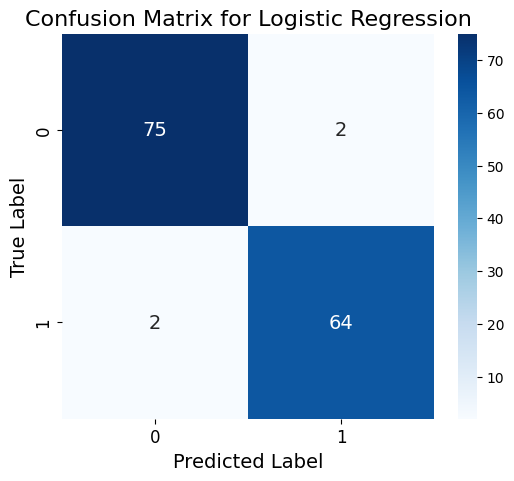

SVM Performance:
  Accuracy: 0.972027972027972
  AUC: 0.9838646202282566
  Sensitivity (Recall): 0.9696969696969697
  Specificity: 0.974025974025974
  PPV (Precision): 0.9696969696969697
  NPV: 0.974025974025974
  F1 Score: 0.9696969696969697



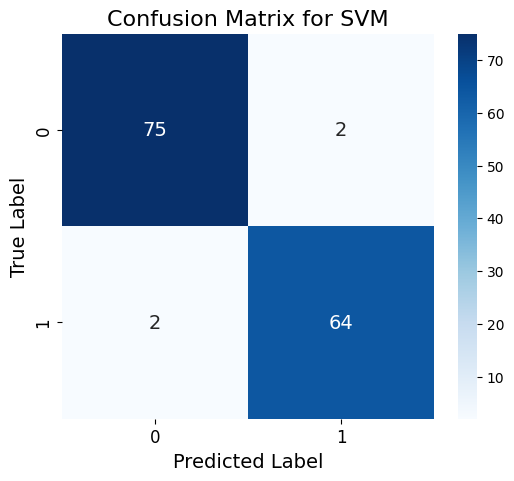

XGBoost Performance:
  Accuracy: 0.965034965034965
  AUC: 0.9748130657221568
  Sensitivity (Recall): 0.9696969696969697
  Specificity: 0.961038961038961
  PPV (Precision): 0.9552238805970149
  NPV: 0.9736842105263158
  F1 Score: 0.9624060150375939



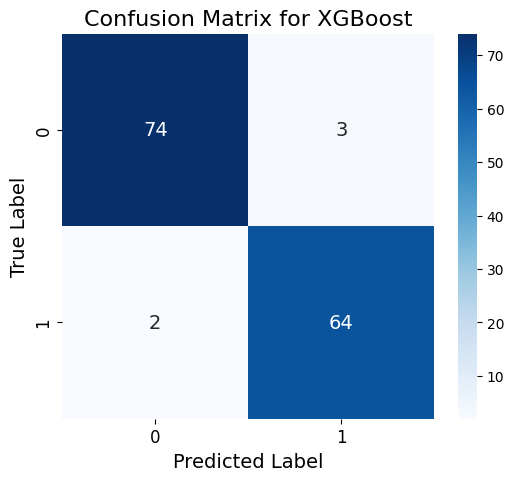

In [34]:
# TESTING PREDUCTIONS
# Prepare the test data
X_test = test_data[RFE_selected_features_withHighAUC]
y_test = test_data['Malignant']

# Define the best models
models = {
    'Logistic Regression': LogisticRegression(C=10, solver='liblinear'),
    'SVM': SVC(C=0.1, gamma='scale', kernel='linear', probability=True),
    'XGBoost': XGBClassifier(learning_rate=0.3, max_depth=2, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
}

# Function to calculate specificity and NPV
def specificity_npv(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    npv = tn / (tn+fn)
    return specificity, npv

# Plot Confusion Matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# External validation/testing
for model_name, model in models.items():
    model.fit(X[RFE_selected_features_withHighAUC], y)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [None] * len(y_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba[0] is not None else "Not Applicable"
    sensitivity = recall_score(y_test, y_pred)
    specificity, npv = specificity_npv(y_test, y_pred)
    ppv = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print performance metrics
    print(f"{model_name} Performance:")
    print(f"  Accuracy: {accuracy}")
    print(f"  AUC: {auc}")
    print(f"  Sensitivity (Recall): {sensitivity}")
    print(f"  Specificity: {specificity}")
    print(f"  PPV (Precision): {ppv}")
    print(f"  NPV: {npv}")
    print(f"  F1 Score: {f1}\n")

    # Plotting Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)

Feature: area_mean
  Group 0 - Median: -0.5944936752056016, 25th percentile: -0.8573797867477945, 75th percentile: -0.29063404253775493
  Group 1 - Median: 0.9543054233441014, 25th percentile: 0.24103836758872488, 75th percentile: 1.7475579909854244
  Mann-Whitney U test - U Statistic: 6991.5, P-value: 3.523657278407042e-94

Feature: concavity_mean
  Group 0 - Median: -0.675106405084739, 25th percentile: -0.9023688341383252, 75th percentile: -0.36495684457656713
  Group 1 - Median: 0.8256653329026201, 25th percentile: 0.30464124337214815, 75th percentile: 1.4459644539189638
  Mann-Whitney U test - U Statistic: 7308.5, P-value: 3.7780514713097896e-93

Feature: concave_points_mean
  Group 0 - Median: -0.6678853907318336, 25th percentile: -0.8918234917961575, 75th percentile: -0.42665990656872
  Group 1 - Median: 0.9382709100747326, 25th percentile: 0.42733681851149846, 75th percentile: 1.4661253592384234
  Mann-Whitney U test - U Statistic: 3991.5, P-value: 3.444921264938632e-104

Featur

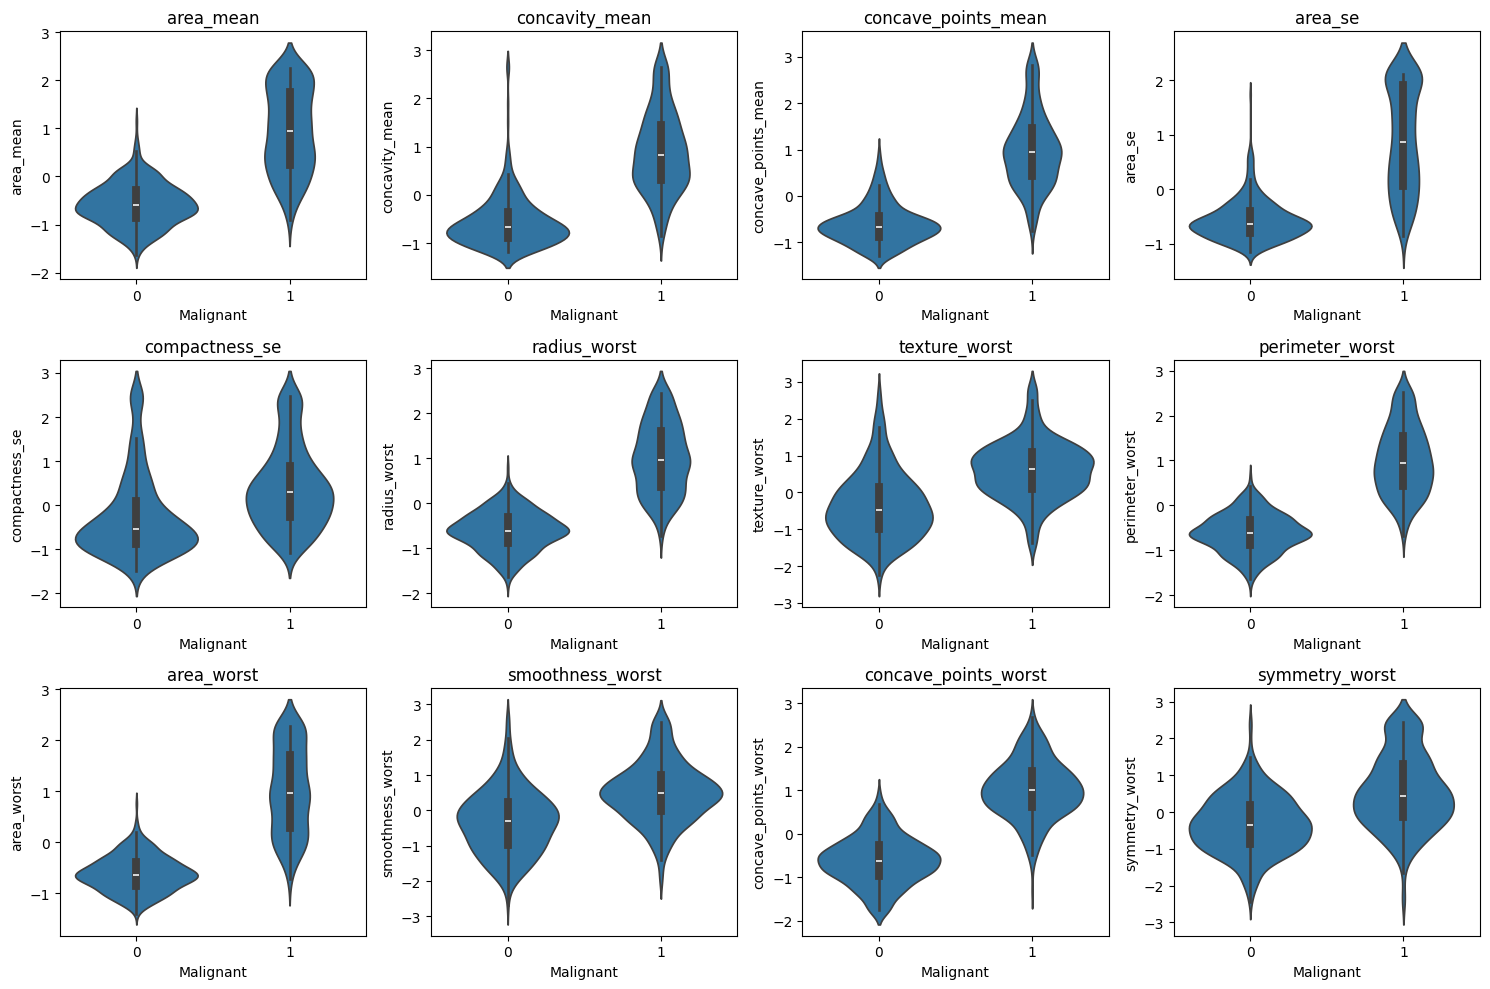

In [35]:
# descriptive stats
RFE_selected_features_withHighAUC = ['area_mean', 'concavity_mean', 'concave_points_mean', 'area_se',
                                     'compactness_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
                                     'area_worst', 'smoothness_worst', 'concave_points_worst', 'symmetry_worst']

# Split the data into two groups
group_0 = bca_processed[bca_processed['Malignant'] == 0]
group_1 = bca_processed[bca_processed['Malignant'] == 1]

# Compare median, 25th percentile, and 75th percentile, and perform Mann-Whitney U test
for feature in RFE_selected_features_withHighAUC:
    median_0 = np.median(group_0[feature])
    percentile_25_0 = np.percentile(group_0[feature], 25)
    percentile_75_0 = np.percentile(group_0[feature], 75)

    median_1 = np.median(group_1[feature])
    percentile_25_1 = np.percentile(group_1[feature], 25)
    percentile_75_1 = np.percentile(group_1[feature], 75)

    u_statistic, p_value = mannwhitneyu(group_0[feature], group_1[feature])

    print(f"Feature: {feature}")
    print(f"  Group 0 - Median: {median_0}, 25th percentile: {percentile_25_0}, 75th percentile: {percentile_75_0}")
    print(f"  Group 1 - Median: {median_1}, 25th percentile: {percentile_25_1}, 75th percentile: {percentile_75_1}")
    print(f"  Mann-Whitney U test - U Statistic: {u_statistic}, P-value: {p_value}\n")

# Set the size of the overall figure
plt.figure(figsize=(15, 10))

# Loop through each feature and create a subplot for each
for i, feature in enumerate(RFE_selected_features_withHighAUC, start=1):
    plt.subplot(3, 4, i)  # Adjust the grid dimensions as per the number of features
    sns.violinplot(x='Malignant', y=feature, data=bca_processed)
    plt.title(feature)

plt.tight_layout()
plt.show()